# Machine Learning API

> ICDSS Machine Learning Workshop Series: Coding Models on `scikit-learn`, `keras` & `fbprophet`

* [Pipeline](#pipeline)
    * [Preprocessing](#pipe:preprocessing)
    * [Estimation](#pipe:estimation)
        * [Supervised Learning](#pipe:supervised-learning)
        * [Unsupervised Learning](#pipe:unsupervised-learning)
    * [Evaluation](#pipe:evaluation)
* [`scikit-learn`](#scikit-learn)
    * [Preprocessing](#sk:preprocessing)
    * [Estimation](#sk:estimation)
        * [Classifiers](#sk:classifiers)
        * [Regressors](#sk:regressors)
    * [Evaluation](#sk:evaluation)
        * [Categorical Output](#sk:categorical-output)
        * [Continuous Output](#sk:continous-output)
    * [Model Selection](#sk:model-selection)
        * [Hyperparameters](#sk:hyperparameters)
        * [`GridSearchCV`](#sk:GridSearchCV)
    * [Pipeline](#sk:pipeline)
        * [Steps](#sk:steps)
        * [Complete](#sk:complete)
    * [`tpot`](#sk:tpot)
* [`keras`](#keras)
    * [Dense](#keras:dense)
        * [Iris](#keras:iris)
    * [CNN](#keras:cnn)
        * [Fashion MNIST](#keras:fashion-mnist)
    * [LSTM](#keras:lstm)
        * [President Trump Generator](#keras:president-trump-generator)
* [`fbprophet`](#fbprophet)
    * [Bitcoin Capital Market](#fbprophet:bitcoin-capital-market)

## Pipeline <a class="anchor" id="pipeline"></a>

<img src="assets/Pipeline.png" alt="Drawing" style="width: 750px;"/>

### Preprocessing <a class="anchor" id="pipe:preprocessing"></a>

TODO:
- skeleton, comment methods
- exercise: $(x_{1}, x_{2}) \rightarrow (x_{1}, x_{2}, x_{1}x_{2}, x_{1}^{2}, x_{2}^{2})$ (~2min)

In [ ]:
class Preprocessor:
    
    def __init__(self):
        raise NotImplementedError
    
    def fit(self, X_train):
        raise NotImplementedError
    
    def transform(self, X):
        raise NotImplementedError
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

### Estimation <a class="anchor" id="pipe:estimation"></a>

TODO:
- skeleton, comment methods
- exercise: Linear Regression (~3min) given the $w_{MLE}$

In [ ]:
class Estimator:
    
    def __init__(self, param_a, param_b):
        self.param_a = param_a
        self.param_c = param_b**2
    
    def fit(self, X_train, y_train):
        return self
    
    def predict(self, X, y):
        return X, y
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return self._loss(y, y_hat)
    
    def _loss(self, y, y_hat):
        return L(y, y_hat)

### Evaluation <a class="anchor" id="pipe:evaluation"></a>

TODO:
- skeleton, comment methods
- exercise: Elastic Net (~2 min) given the formula

In [ ]:
class EvalEstimator(Estimator):
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return self._loss(y, y_hat)
    
    def _loss(self, y, y_hat):
        return L(y, y_hat)

## `scikit-learn` <a class="anchor" id="scikit-learn"></a>

### Preprocessing <a class="anchor" id="sk:preprocessing"></a>

### Estimation <a class="anchor" id="sk:estimation"></a>

### Model Selection <a class="anchor" id="sk:model-selection"></a>

#### Hyperparameters <a class="anchor" id="sk:hyperparameters"></a>

### Evaluation <a class="anchor" id="sk:evaluation"></a>

### `tpot` <a class="anchor" id="sk:tpot"></a>

## `keras` <a class="anchor" id="keras"></a>

### Iris Dataset <a class="anchor" id="keras:iris"></a>

In [24]:
%reset -f

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Activation
from keras.optimizers import RMSprop
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### Data & Preprocessing

In [ ]:
# fetch data
iris = datasets.load_iris()

# split to train/test datasets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target)
# one-hot encode categorical output
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# matrix shapes
N_train, D = X_train.shape
N_test, _ = X_test.shape
_, M = y_train_one_hot.shape

#### Feedforward Neural Network

In [ ]:
# input layer
X = Input(shape=(D,), name="X")

# Convolution Layer
A1 = Dense(16, name="A1")(X)
# Non-Linearity
Z1 = Activation("relu", name="Z1")(A1)
# Affine Layer
A2 = Dense(M, name="A2")(Z1)
# Multi-Class Classification
Y = Activation("softmax", name="Y")(A2)

# Define Graph
model = Model(inputs=X, outputs=Y)
# Compile Graph
model.compile(optimizer=RMSprop(lr=0.04),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Computational Graph Summary
model.summary()

In [ ]:
# model training
history = model.fit(X_train, y_train_one_hot, epochs=100, validation_split=0.25, verbose=0)

#### Evaluation

In [ ]:
y_hat_one_hot = model.predict(X_test)

# one-hot-encoded to raw data
y_hat = np.argmax(y_hat_one_hot, axis=1)

# confusion matrix
cm = confusion_matrix(y_test, y_hat)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
_, ax = plt.subplots(figsize=(7.0, 6.0))
sns.heatmap(cm_norm, annot=True, cmap=plt.cm.Blues, ax=ax)
ax.set_xticklabels(iris.target_names, rotation=45)
ax.set_yticklabels(iris.target_names, rotation=45)
ax.set_title('Iris Dataset Confusion Matrix')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class');

### Fashion MNIST <a class="anchor" id="keras:fashion-mnist"></a>

In [ ]:
%reset -f

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import RMSprop
from keras.utils import to_categorical

from keras.datasets import fashion_mnist

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

np.random.seed(0)

#### Data & Preprocessing

In [ ]:
# fetch data
(X_train_raw, y_train), (X_test_raw, y_test) = fashion_mnist.load_data()
# one-hot encode categorical output
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# tensor shape
N_train, h, w = X_train_raw.shape
N_test, _, _ = X_test_raw.shape
_, M = y_train_one_hot.shape

# convert raw pixels to tensors
X_train = X_train_raw.reshape(-1, h, w, 1)
X_test = X_test_raw.reshape(-1, h, w, 1)

#### Convolutional Neural Network

In [ ]:
# input layer: shape=(height, width, number of channels)
X = Input(shape=(h, w, 1), name="X")

# Convolution Layer
CONV1 = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", name="CONV1")(X)
# Max Pooling Layer
POOL1 = MaxPooling2D(pool_size=(2, 2), name="POOL1")(CONV1)
# Convolution Layer
CONV2 = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", name="CONV2")(POOL1)
# Max Pooling Layer
POOL2 = MaxPooling2D(pool_size=(2, 2), name="POOL2")(CONV2)
# Convolution Layer
CONV3 = Conv2D(filters=64, kernel_size=(3, 3), activation="relu", name="CONV3")(POOL2)
# Max Pooling Layer
POOL3 = MaxPooling2D(pool_size=(2, 2), name="POOL3")(CONV3)
# Convert 3D feature map to 1D
FLAT = Flatten()(POOL3)
# Fully Connected Layer
FC1 = Dense(units=64, name="FC1")(FLAT)
# Dropout
DROP = Dropout(rate=0.5, name="DROP")(FC1)
# Multi-Class Classification Output Layer
Y = Dense(M, activation="softmax", name="Y")(DROP)

# Define Graph
model = Model(inputs=X, outputs=Y)
# Compile Graph
model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Computational Graph Summary
model.summary()

In [ ]:
# model training
history = model.fit(X_train, y_train_one_hot, batch_size=128, epochs=3, validation_split=0.25, verbose=0)

#### Evaluation

In [ ]:
y_hat_one_hot = model.predict(X_test)

# one-hot-encoded to raw data
y_hat = np.argmax(y_hat_one_hot, axis=1)

# confusion matrix
cm = confusion_matrix(y_test, y_hat)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
_, ax = plt.subplots(figsize=(7.0, 6.0))
sns.heatmap(cm_norm, annot=True, cmap=plt.cm.Greens, ax=ax)
ax.set_title('Fashion MNIST Dataset Confusion Matrix')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class');

### President Trump Generator <a class="anchor" id="keras:president-trump-generator"></a>

In [1]:
%reset -f

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from keras.datasets import fashion_mnist

import numpy as np

np.random.seed(0)

/Users/omega/Developer/icdss/Machine-Learning-API/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Data & Preprocessing

In [2]:
# fetch data
with open("data/trump/speeches.txt") as corpus_file:
    corpus = corpus_file.read()
print("Loaded a corpus of {0} characters".format(len(corpus)))
corpus_length = len(corpus)

# Get a unique identifier for each char in the corpus
# then make some dicts to ease encoding and decoding
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))

# it slices, it dices, it makes julienned datasets!
# chop up our data into X and y, slice into roughly (num_chars / skip) overlapping 'sentences'
# of length sentence_length, and encode the chars
sentence_length = 50
skip = 1
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}".format(num_sentences, sentence_length))

# Vectorize our data and labels. We want everything in one-hot
# because smart data encoding cultivates phronesis and virtue.
print("Vectorizing X and y...")
X = np.zeros((num_sentences, sentence_length, num_chars), dtype=np.bool)
y = np.zeros((num_sentences, num_chars), dtype=np.bool)
for i, sentence in enumerate(X_data):
    for t, encoded_char in enumerate(sentence):
        X[i, t, encoded_char] = 1
    y[i, y_data[i]] = 1

# Double check our vectorized data before we sink hours into fitting a model
print("Sanity check y. Dimension: {0} # Sentences: {1} Characters in corpus: {2}".format(y.shape, num_sentences, len(chars)))
print("Sanity check X. Dimension: {0} Sentence length: {1}".format(X.shape, sentence_length))

Loaded a corpus of 132087 characters
Our corpus contains 86 unique characters.
Sliced our corpus into 132037 sentences of length 50
Vectorizing X and y...
Sanity check y. Dimension: (132037, 86) # Sentences: 132037 Characters in corpus: 86
Sanity check X. Dimension: (132037, 50, 86) Sentence length: 50


#### Recurrent Neural Network

In [3]:
model = Sequential()
model.add(LSTM(units=256, input_shape=(sentence_length, num_chars), name="LSTM"))
model.add(Dense(units=num_chars, activation="softmax", name="Y"))

# Compile Graph
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy')
# Computational Graph Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 256)               351232    
_________________________________________________________________
Y (Dense)                    (None, 86)                22102     
Total params: 373,334
Trainable params: 373,334
Non-trainable params: 0
_________________________________________________________________


In [5]:
# remove this line to train the model again
if None:
    # Dump our model architecture to a file so we can load it elsewhere
    architecture = model.to_yaml()
    with open('models/trump.yaml', 'a') as model_file:
        model_file.write(architecture)

    # Set up checkpoints
    file_path="models/trump-weights-{epoch:02d}-{loss:.3f}.hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor="loss", verbose=1, save_best_only=True, mode="min")
    callbacks = [checkpoint]

    # model training
    history = model.fit(X, y, epochs=30, batch_size=256, callbacks=callbacks)
else:
    # load weights from checkpoint
    model.load_weights("models/trump-weights-03-2.152.hdf5")

#### Helper Functions

In [6]:
def generate(seed_pattern):
    X = np.zeros((1, sentence_length, num_chars), dtype=np.bool)
    for i, character in enumerate(seed_pattern):
        X[0, i, encoding[character]] = 1

    generated_text = ""
    for i in range(10):
        prediction = np.argmax(model.predict(X, verbose=0))

        generated_text += decoding[prediction]

        activations = np.zeros((1, 1, num_chars), dtype=np.bool)
        activations[0, 0, prediction] = 1
        X = np.concatenate((X[:, 1:, :], activations), axis=1)

    return generated_text

def make_seed(seed_phrase=""):
    if seed_phrase:
        phrase_length = len(seed_phrase)
        pattern = ""
        for i in range (0, sentence_length):
            pattern += seed_phrase[i % phrase_length]
    else:
        seed = randint(0, corpus_length - sentence_length)
        pattern = corpus[seed:seed + sentence_length]

    return pattern

#### Evaluation

In [7]:
# seed letter
seed = "b"
# prediction
seed + generate(make_seed(seed))

'be the wall'

## `fbprophet` <a class="anchor" id="fbprophet"></a>

In [25]:
%reset -f

from fbprophet import Prophet

import pandas_datareader.data as web

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)

#### Data & Preprocessing

In [26]:
# fetch data
btc = web.DataReader("BCHARTS/KRAKENUSD", data_source="quandl").dropna()

# time-series DataFrame
df = pd.DataFrame(columns=["ds", "y"])
df["ds"] = btc.index
# market capital column
df["y"] = (btc["Close"] * btc["VolumeBTC"]).values

df.head()

,ds,y
0,2018-03-04,4.449157e+07
1,2018-03-03,5.650515e+07
2,2018-03-02,6.330346e+07
3,2018-03-01,8.574683e+07
4,2018-02-28,8.817605e+07


#### MAP Optimization and Hamiltonian Monte Carlo Inference

In [27]:
# define model
model = Prophet()

# train model
model.fit(df);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/omega/Developer/icdss/Machine-Learning-API/.env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


#### Evaluation

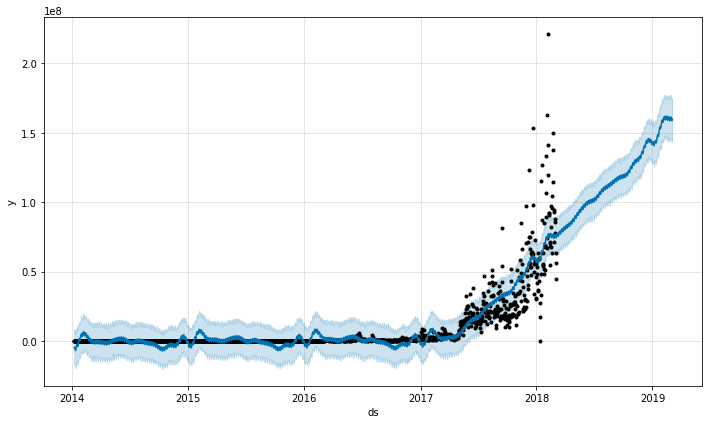

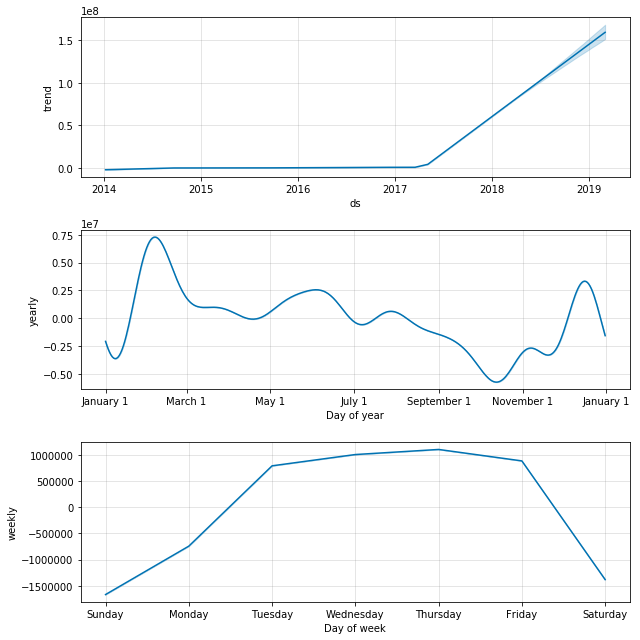

In [29]:

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# generate plots
model.plot(forecast);
model.plot_components(forecast);

## Disclaimer

Presentations are intended for educational purposes only and do not replace independent professional judgment.
Statements of fact and opinions expressed are those of the participants individually and,
unless expressly stated to the contrary, are not the opinion or position of the ICDSS, its cosponsors, or its committees.
The ICDSS does not endorse or approve, and assumes no responsibility for, the content,
accuracy or completeness of the information presented.
Attendees should note that sessions are video-recorded and may be published in various media, including print,
audio and video formats without further notice.